# Document Classification Example with Neural Networks

In this document, the performance of Deep Learning algorithms (Multilayer Perceptron and Conventional Neural Networks) is tested for a image classification problem. The images to classify belongs to 4 different documents: laboral contracts, Spanish ID cards, invoices and payrolls.

### 1. Load libraries

We first load the necessary libraries to run the current investigation.

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import np_utils
import os
import cv2
from imutils import paths
import numpy as np
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib inline

### 2. Helpers functions

In this section section, we will define helper functions that will be used in the rest of the analysis.

In [3]:
images_path = '/home/raul/GIT/tfm/Notebooks/deep_learning/images/'
models_path = '/home/raul/GIT/tfm/Notebooks/deep_learning/models/'
def get_input_shape(starndard_size):
    if K.image_data_format() == 'channels_first':
        input_shape = (3, starndard_size, starndard_size)
    else:
        input_shape = (starndard_size, starndard_size, 3)

    return input_shape

def image_to_feature_vector(image, size, flaten=False):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    result = None
    try:
        if not flaten:
            result = cv2.resize(image, size)
        else:
            result = cv2.resize(image, size).flatten()
    except:
        print("Error loading image ", image)

    return result

def get_lab_images(dataPath, starndard_size, verbose=False, flaten=False):
    imagePaths = list(paths.list_images(dataPath))
    freq_verbose = int(len(imagePaths)/25)
    data = []
    ini_labels = []
    for (i, imagePath) in enumerate(imagePaths):
        try:
            # load the image and extract the class label (assuming that our
            # path as the format: /path/to/dataset/{class}.{image_num}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-1].split("_")[0]

            # construct a feature vector raw pixel intensities, then update
            # the data matrix and labels list
            features = image_to_feature_vector(image, size=(starndard_size, starndard_size), 
                                               flaten=flaten)

            if features is not None:
                data.append(features)
                ini_labels.append(label)
        except:
            print("Error loading image ", imagePath)

        if verbose:
            # show an update every 50 images
            if i > 0 and i % freq_verbose == 0:
                print("[INFO] processed {}/{}".format(i, len(imagePaths)))

    return data, ini_labels

def cure_data(data, ini_labels, num_classes):
    le = LabelEncoder()
    labels = le.fit_transform(ini_labels)
    data = np.array(data) / 255.0
    labels = np_utils.to_categorical(labels, num_classes)

    return data, labels

def config_convNd(input_shape, n_classes, epochs, lrate = 0.01):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same',
                     activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    lrate = lrate
    decay = lrate / epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd, metrics=['accuracy'])

    return model


def config_conv2d(input_shape, last_dense):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    #     model.add(Dense(1))
    model.add(Dense(last_dense))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop', metrics=['accuracy'])

    return model


def config_mlp(input_shape, n_classes, epochs, lrate = 0.01):

    # define the architecture of the network
    model = Sequential()
    model.add(Dense(int(input_shape/4), input_dim=input_shape, init="uniform", activation="relu"))
    ## 768 = 3072/4, input_dim = 32*32*3

    model.add(Dense(int(input_shape/8), init="uniform", activation="relu"))
    ## 384 = 768/2

    model.add(Dense(n_classes))
    ## 2 --> Number of final claseses

    model.add(Activation("softmax"))

    decay = lrate / epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    ## lr = 0.01, learning rate
    model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
    
    return model

def save_model(model, model_name, weights_name):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weights_name)
    print("Saved model to disk")
    
    
def load_model(model_name, weights_name, epochs):

    # load json and create model
    json_file = open(model_name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_name)
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    loaded_model.compile(loss='categorical_crossentropy', 
                  optimizer=sgd, metrics=['accuracy'])

    return loaded_model


def get_flatten_labels(array):
    return np.asarray([np.where(item==1)[0][0] for item in array])

### 2. Variables definition

Now we define some variables used in the rest of the analysis.

In [17]:
STANDARD_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 75
BATCH_SIZE = 128
dataPath  = "/home/raul/data_tfm_rsm/documents/data_train/"
input_shape = get_input_shape(starndard_size = STANDARD_SIZE)
print("Input shape ", input_shape)

Input shape  (32, 32, 3)


### 3. Multilayer Perceptron

We first start studing the Multilayer Perceptron model.

#### 3.1 Multilayer Perceptron: Data Loading

We first load the data in the correct format.

In [5]:
ini_data_mlp, ini_labels_mlp = get_lab_images(dataPath, starndard_size = STANDARD_SIZE,
                                              verbose=True, flaten=True)

[INFO] processed 398/9957
[INFO] processed 796/9957
[INFO] processed 1194/9957
[INFO] processed 1592/9957
[INFO] processed 1990/9957
[INFO] processed 2388/9957
[INFO] processed 2786/9957
[INFO] processed 3184/9957
[INFO] processed 3582/9957
[INFO] processed 3980/9957
[INFO] processed 4378/9957
[INFO] processed 4776/9957
[INFO] processed 5174/9957
[INFO] processed 5572/9957
[INFO] processed 5970/9957
[INFO] processed 6368/9957
[INFO] processed 6766/9957
[INFO] processed 7164/9957
[INFO] processed 7562/9957
[INFO] processed 7960/9957
[INFO] processed 8358/9957
[INFO] processed 8756/9957
[INFO] processed 9154/9957
[INFO] processed 9552/9957
[INFO] processed 9950/9957


We check that everything is working fine.

In [6]:
print(len(ini_data_mlp), len(ini_labels_mlp))

9957 9957


In [7]:
print(ini_labels_mlp[0])

contrato


In [8]:
# data_mlp, labels_mlp = cure_data(ini_data_mlp, ini_labels_mlp, num_classes=NUM_CLASSES)
le = LabelEncoder()
labels = le.fit_transform(ini_labels_mlp)
data_mlp = np.array(ini_data_mlp) / 255.0
labels_mlp = np_utils.to_categorical(labels, NUM_CLASSES)

In [9]:
print(len(data_mlp), len(labels_mlp))

9957 9957


In [10]:
print(labels_mlp[0])

[ 1.  0.  0.  0.]


Now we split the data into train and test.

In [11]:
(train_data_mlp, test_data_mlp, train_labels_mlp, test_labels_mlp) = train_test_split(
    data_mlp, labels_mlp, test_size=0.25, random_state=42)

#### 3.2 Multilayer Perceptron: Training

Now we train and test the Multilayer Perceptron model.

In [18]:
model_mlp = config_mlp(input_shape = STANDARD_SIZE*STANDARD_SIZE*3, 
                       n_classes = NUM_CLASSES, 
                       epochs=EPOCHS)

/home/raul/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:118: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(768, input_dim=3072, activation="relu", kernel_initializer="uniform")`
/home/raul/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:121: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(384, activation="relu", kernel_initializer="uniform")`


In [19]:
model_mlp.fit(train_data_mlp, train_labels_mlp, validation_data=(test_data_mlp, test_labels_mlp), 
              epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 7467 samples, validate on 2490 samples
Epoch 1/75
7467/7467 [==============================] - 5s - loss: 1.3634 - acc: 0.3657 - val_loss: 1.3140 - val_acc: 0.3594
Epoch 2/75
7467/7467 [==============================] - 4s - loss: 1.2335 - acc: 0.4085 - val_loss: 1.1588 - val_acc: 0.4940
Epoch 3/75
7467/7467 [==============================] - 4s - loss: 1.1337 - acc: 0.4910 - val_loss: 1.1215 - val_acc: 0.4209
Epoch 4/75
7467/7467 [==============================] - 4s - loss: 1.2366 - acc: 0.4170 - val_loss: 1.2811 - val_acc: 0.4181
Epoch 5/75
7467/7467 [==============================] - 4s - loss: 1.1212 - acc: 0.4725 - val_loss: 1.3905 - val_acc: 0.3490
Epoch 6/75
7467/7467 [==============================] - 4s - loss: 1.0555 - acc: 0.5157 - val_loss: 1.0188 - val_acc: 0.5522
Epoch 7/75
7467/7467 [==============================] - 4s - loss: 1.0323 - acc: 0.5315 - val_loss: 1.0324 - val_acc: 0.5434
Epoch 8/75
7467/7467 [==============================] - 4s - loss: 1.0431 - a

In [20]:
model_name_mlp = models_path + "model_mlp.json"
weights_name_mlp = models_path +"model_mlp.h5"

save_model(model_mlp, model_name_mlp, weights_name_mlp)

Saved model to disk


#### 3.3 Multilayer Perceptron: Testing

Now we test the model trained in the previous section.

In [21]:
print("[INFO] Evaluating MLP model...")

(loss_mlp, accu_mlp) = model_mlp.evaluate(test_data_mlp, test_labels_mlp, 
                                          batch_size=BATCH_SIZE, verbose=1)

[INFO] Evaluating MLP model...
2432/2490 [============================>.] - ETA: 0s

In [22]:
print("[INFO] loss_mlp={:.4f}, accuracy_mlp: {:.4f}%".format(loss_mlp, 
                                                             accu_mlp * 100))

[INFO] loss_mlp=0.9625, accuracy_mlp: 59.3574%


In [23]:
predictions_mlp = model_mlp.predict_classes(test_data_mlp)

2464/2490 [============================>.] - ETA: 0s

In [24]:
flatten_labels_mlp = get_flatten_labels(test_labels_mlp)

In [25]:
crosstab_df_mlp = pd.crosstab(flatten_labels_mlp, predictions_mlp, rownames=["Actual"], colnames=["Predicted"])
pd.crosstab(flatten_labels_mlp, predictions_mlp, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2,3
Actual,,,,
0,266,94,127,134
1,9,574,21,3
2,60,141,288,151
3,49,44,179,350


In [26]:
labels_dict = {"contrato":0, "dni":1, "factura":2, "nomina":3}
actual_val_mlp = np.asarray(crosstab_df_mlp.sum(axis=1))
predictions_mlp = np.diag(crosstab_df_mlp)
partial_pred_mlp = predictions_mlp/actual_val_mlp
total_pred_mlp = sum(predictions_mlp)/sum(actual_val_mlp)

In [27]:
accu_dict_mlp = {"documento":[partial_pred_mlp[0], partial_pred_mlp[1],
                         partial_pred_mlp[2], partial_pred_mlp[3],
                         total_pred_mlp]}

accu_df_mlp = pd.DataFrame(data = accu_dict_mlp, index = ["contrato", "dni", "factura", 
                                                    "nomina", "total"],
                           columns = ["documento"])

print(accu_df_mlp)

          documento
contrato   0.428341
dni        0.945634
factura    0.450000
nomina     0.562701
total      0.593574


Now we plot the glocal accuracy and the accuracy per image.

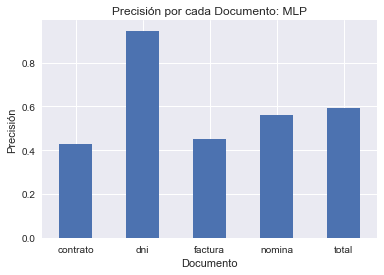

In [28]:
mlp_results = accu_df_mlp.plot(kind="bar", rot=0, legend=False)
mlp_results.set_xlabel("Documento")
mlp_results.set_ylabel("Precisión")
mlp_results.set_title("Precisión por cada Documento: MLP")
plt.savefig(images_path+'analysis_mlp.pdf')

As you can see, while the accuracy regarding the DNI is very high, the accuracy for the rest of documents ranges between 0.4 and 0.6, with a global accuracy of 0.6.

### 4. Convolutional Neural Network

Now, we will repeat the process but in this case for the Convolutional Neural Network.

#### 4.1 Convolutional Neural Network: Data Loading

In [29]:
ini_data_cnn, ini_labels_cnn = get_lab_images(dataPath, starndard_size = STANDARD_SIZE,
                                              verbose = True)

[INFO] processed 398/9957
[INFO] processed 796/9957
[INFO] processed 1194/9957
[INFO] processed 1592/9957
[INFO] processed 1990/9957
[INFO] processed 2388/9957
[INFO] processed 2786/9957
[INFO] processed 3184/9957
[INFO] processed 3582/9957
[INFO] processed 3980/9957
[INFO] processed 4378/9957
[INFO] processed 4776/9957
[INFO] processed 5174/9957
[INFO] processed 5572/9957
[INFO] processed 5970/9957
[INFO] processed 6368/9957
[INFO] processed 6766/9957
[INFO] processed 7164/9957
[INFO] processed 7562/9957
[INFO] processed 7960/9957
[INFO] processed 8358/9957
[INFO] processed 8756/9957
[INFO] processed 9154/9957
[INFO] processed 9552/9957
[INFO] processed 9950/9957


In [30]:
print(len(ini_data_cnn), len(ini_labels_cnn))

9957 9957


In [31]:
print(ini_labels_cnn[0])

contrato


In [32]:
data_cnn, labels_cnn = cure_data(ini_data_cnn, ini_labels_cnn, num_classes=NUM_CLASSES)

In [33]:
print(len(data_cnn), len(labels_cnn))

9957 9957


In [34]:
print(labels_cnn[0])

[ 1.  0.  0.  0.]


In [35]:
(train_data_cnn, test_data_cnn, train_labels_cnn, test_labels_cnn) = train_test_split(
    data_cnn, labels_cnn, test_size=0.25, random_state=42)

#### 4.2 Convolutional Neural Network: Training

In [36]:
model_cnn = config_convNd(input_shape = input_shape, 
                         n_classes = NUM_CLASSES, 
                         epochs=EPOCHS)

In [37]:
EPOCHS = 35
model_cnn.fit(train_data_cnn, train_labels_cnn, validation_data=(test_data_cnn, test_labels_cnn), 
              epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 7467 samples, validate on 2490 samples
Epoch 1/35
7467/7467 [==============================] - 45s - loss: 1.3709 - acc: 0.3151 - val_loss: 1.3410 - val_acc: 0.2932
Epoch 2/35
7467/7467 [==============================] - 49s - loss: 1.3323 - acc: 0.3439 - val_loss: 1.3370 - val_acc: 0.2438
Epoch 3/35
7467/7467 [==============================] - 59s - loss: 1.2343 - acc: 0.4157 - val_loss: 1.1454 - val_acc: 0.4928
Epoch 4/35
7467/7467 [==============================] - 54s - loss: 1.0359 - acc: 0.5137 - val_loss: 0.9834 - val_acc: 0.5598
Epoch 5/35
7467/7467 [==============================] - 43s - loss: 0.9661 - acc: 0.5637 - val_loss: 0.9612 - val_acc: 0.6020
Epoch 6/35
7467/7467 [==============================] - 46s - loss: 0.9089 - acc: 0.6131 - val_loss: 0.8781 - val_acc: 0.6265
Epoch 7/35
7467/7467 [==============================] - 44s - loss: 0.8629 - acc: 0.6361 - val_loss: 0.8654 - val_acc: 0.6514
Epoch 8/35
7467/7467 [==============================] - 46s - loss: 0.

In [38]:
model_name_cnn = models_path + "model_cnn.json"
weights_name_cnn = models_path + "model_cnn.h5"

save_model(model_cnn, model_name_cnn, weights_name_cnn)

Saved model to disk


#### 4.3 Convolutional Neural Network: Evaluation

In [39]:
print("[INFO] Evaluating CNN model...")

(loss_cnn, accu_cnn) = model_cnn.evaluate(test_data_cnn, test_labels_cnn, 
                                          batch_size=BATCH_SIZE, verbose=1)

[INFO] Evaluating CNN model...
2490/2490 [==============================] - 3s     


In [40]:
print("[INFO] loss_cnn={:.4f}, accuracy_cnn: {:.4f}%".format(loss_cnn, 
                                                             accu_cnn * 100))

[INFO] loss_cnn=0.5749, accuracy_cnn: 78.7149%


In [41]:
predictions_cnn = model_cnn.predict_classes(test_data_cnn)

2464/2490 [============================>.] - ETA: 0s

In [42]:
flatten_labels = get_flatten_labels(test_labels_cnn)

In [43]:
crosstab_df_cnn = pd.crosstab(flatten_labels, predictions_cnn, rownames=["Actual"], colnames=["Predicted"])
pd.crosstab(flatten_labels, predictions_cnn, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2,3
Actual,,,,
0,512,7,36,66
1,0,595,12,0
2,77,61,404,98
3,97,8,68,449


In [44]:
labels_dict = {"contrato":0, "dni":1, "factura":2, "nomina":3}
actual_val_cnn = np.asarray(crosstab_df_cnn.sum(axis=1))
predictions_cnn = np.diag(crosstab_df_cnn)
partial_pred_cnn = predictions_cnn/actual_val_cnn
total_pred_cnn = sum(predictions_cnn)/sum(actual_val_cnn)

In [45]:
accu_dict_cnn = {"documento":[partial_pred_cnn[0], partial_pred_cnn[1],
                         partial_pred_cnn[2], partial_pred_cnn[3],
                         total_pred_cnn]}

accu_df_cnn = pd.DataFrame(data = accu_dict_cnn, index = ["contrato", "dni", "factura", 
                                                    "nomina", "total"],
                           columns = ["documento"])

print(accu_df_cnn)

          documento
contrato   0.824477
dni        0.980231
factura    0.631250
nomina     0.721865
total      0.787149


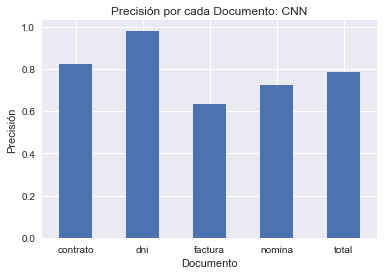

In [46]:
cnn_results = accu_df_cnn.plot(kind="bar", rot=0, legend=False)
cnn_results.set_xlabel("Documento")
cnn_results.set_ylabel("Precisión")
cnn_results.set_title("Precisión por cada Documento: CNN")
plt.savefig(images_path+'analysis_cnn.pdf')

As you can see, the global accuracy is close to ~0.8. While the accuracy for the DNI is close to 1, the accuracy for the rest of the documents range between 0.6 and 0.8